***Challenge 1***

Here the goal is to train on 25 samples. In this preliminary testbed the evaluation will be done on a 2000 sample validation set. Note in the end the final evaluation will be done on the full CIFAR-10 test set as well as potentially a separate dataset. The validation samples here should not be used for training in any way, the final evaluation will provide only random samples of 25 from a datasource that is not the CIFAR-10 training data. 

Feel free to modify this testbed to your liking, including the normalization transformations etc. Note however the final evaluation testbed will have a rigid set of components where you will need to place your answer. The only constraint is the data. Refer to the full project instructions for more information.


Setup training functions. Again you are free to fully modify this testbed in your prototyping within the constraints of the data used. You can use tools outside of pytorch for training models if desired as well although the torchvision dataloaders will still be useful for interacting with the cifar-10 dataset. 

In [51]:
import os
import re
import zipfile
import torch
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as t_models

from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from numpy.random import RandomState
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import GridSearchCV

In [52]:
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [53]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)  

In [54]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 1024)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024,10)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(nn.functional.relu(self.bn2(self.conv3(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        #return torch.nn.functional.sigmoid(x).squeeze(0)
        return torch.nn.functional.softmax(x, dim=1)
        # return x


# Define the augmentation network architecture
class AugNet(nn.Module):
    def __init__(self):
        super(AugNet, self).__init__()
        self.conv1 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.conv5(x)
        return x

In [56]:
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
train_accs = []
test_accs = []

for seed in range(0, 25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  
  config = dict(batch_size=64,
                  epochs=100,
                  learning_rate=0.0001,
                  momentum=0.9,
                  weight_decay=5e-4)
  
  small_net = SmallNet()
  small_net.to(device)

  net_aug = AugNet()
  net_aug.to(device)

  small_net_loss = nn.CrossEntropyLoss()

  optimizer = optim.Adam(list(small_net.parameters()) + list(net_aug.parameters()), lr=config["learning_rate"], weight_decay=config["weight_decay"])

  small_net.train()
  net_aug.train()

  correct = 0
  total = 0
  for epoch in tqdm(range(config['epochs']), desc=f'training model'):
    
    for j, data in enumerate(train_loader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        iter = 0
        for input, label in zip(inputs, labels):
          

          #Original Image
          output_sm1 = small_net(input.unsqueeze(0)).squeeze(0)
          pred = torch.argmax(output_sm1)
          #print(pred)

          if pred == label:
            correct += 1
          total += 1   


          loss_sm1 = small_net_loss(output_sm1, label)

          #Generate Aug Image

          class_indices = [idx for idx, _ in enumerate(inputs) if labels[idx] == label]

          sampled_indices = torch.randperm(len(class_indices))[:3]

          aug_image = torch.cat([inputs[sampled_indices[0]], inputs[sampled_indices[1]]], dim=0).to(device)
          aug_image_compare = inputs[sampled_indices[2]]

          
          output_aug = net_aug(aug_image)
          

          C, W, H = output_aug.shape

          content_loss = torch.sum((output_aug - aug_image_compare) ** 2) / (C * W * H)


          output_sm2 = small_net(output_aug.unsqueeze(0)).squeeze(0)

          pred = torch.argmax(output_sm1)

          if pred == label:
            correct += 1
          total += 1

          loss_sm2 = small_net_loss(output_sm2, label)

          total_loss = 0.75 * (loss_sm1 + loss_sm2) + 0.25 * content_loss

          
          optimizer.zero_grad()
          total_loss.backward()
          optimizer.step()

    acc = 100. * (correct) / total      
  train_accs.append(acc)
  print('Seed {}/{} Loss: {} Accuracy: {:.2f}%'.format(seed + 1, 25, total_loss, acc))
  test_accs.append(test(small_net, device, val_loader))

print(f'Mean Train Acc over 25 models: '\
      f'{np.mean(train_accs)/ 100 :.2%} '\
      f'+- {np.std(train_accs):.2}')

print(f'Mean Val Acc over 25 models: '\
      f'{np.mean(test_accs)/ 100 :.2%} '\
      f'+- {np.std(test_accs):.2}')

Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 1/25 Loss: 2.437941074371338 Accuracy: 98.24%

Test set: Average loss: 1.6733, Accuracy: 316/400 (79.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 2/25 Loss: 3.174437999725342 Accuracy: 77.64%

Test set: Average loss: 1.8024, Accuracy: 266/400 (66.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3/25 Loss: 2.2522451877593994 Accuracy: 96.46%

Test set: Average loss: 1.7905, Accuracy: 268/400 (67.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 4/25 Loss: 2.3682403564453125 Accuracy: 96.84%

Test set: Average loss: 1.7784, Accuracy: 272/400 (68.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 5/25 Loss: 3.058734178543091 Accuracy: 97.16%

Test set: Average loss: 1.7439, Accuracy: 284/400 (71.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 6/25 Loss: 2.506892204284668 Accuracy: 96.78%

Test set: Average loss: 1.9324, Accuracy: 209/400 (52.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 7/25 Loss: 3.2175371646881104 Accuracy: 96.48%

Test set: Average loss: 1.7230, Accuracy: 296/400 (74.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 8/25 Loss: 2.8219988346099854 Accuracy: 96.68%

Test set: Average loss: 1.7335, Accuracy: 290/400 (72.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 9/25 Loss: 2.3429019451141357 Accuracy: 95.18%

Test set: Average loss: 1.6717, Accuracy: 316/400 (79.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 10/25 Loss: 3.2806787490844727 Accuracy: 95.84%

Test set: Average loss: 1.7687, Accuracy: 279/400 (69.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 11/25 Loss: 2.5914363861083984 Accuracy: 94.68%

Test set: Average loss: 1.9081, Accuracy: 222/400 (55.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 12/25 Loss: 3.3853635787963867 Accuracy: 95.86%

Test set: Average loss: 1.7523, Accuracy: 282/400 (70.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 13/25 Loss: 2.6209070682525635 Accuracy: 83.62%

Test set: Average loss: 1.7038, Accuracy: 303/400 (75.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 14/25 Loss: 2.4494667053222656 Accuracy: 96.80%

Test set: Average loss: 1.6727, Accuracy: 319/400 (79.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 15/25 Loss: 2.7222588062286377 Accuracy: 71.04%

Test set: Average loss: 1.6982, Accuracy: 303/400 (75.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 16/25 Loss: 2.313095808029175 Accuracy: 96.50%

Test set: Average loss: 1.7403, Accuracy: 287/400 (71.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 17/25 Loss: 2.7611327171325684 Accuracy: 97.40%

Test set: Average loss: 1.7925, Accuracy: 269/400 (67.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 18/25 Loss: 3.0539896488189697 Accuracy: 95.22%

Test set: Average loss: 1.6768, Accuracy: 313/400 (78.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 19/25 Loss: 3.274312973022461 Accuracy: 94.48%

Test set: Average loss: 1.8751, Accuracy: 231/400 (57.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 20/25 Loss: 2.3996214866638184 Accuracy: 50.14%

Test set: Average loss: 1.9612, Accuracy: 200/400 (50.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 21/25 Loss: 3.167692184448242 Accuracy: 92.72%

Test set: Average loss: 1.7588, Accuracy: 280/400 (70.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 22/25 Loss: 3.3021087646484375 Accuracy: 95.60%

Test set: Average loss: 1.8192, Accuracy: 256/400 (64.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 23/25 Loss: 2.278132438659668 Accuracy: 82.28%

Test set: Average loss: 1.7872, Accuracy: 266/400 (66.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 24/25 Loss: 2.414747476577759 Accuracy: 96.54%

Test set: Average loss: 1.8212, Accuracy: 254/400 (63.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 25/25 Loss: 2.290820360183716 Accuracy: 98.38%

Test set: Average loss: 1.8294, Accuracy: 252/400 (63.00%)

Mean Train Acc over 25 models: 91.54% +- 1.1e+01
Mean Val Acc over 25 models: 68.33% +- 8.0


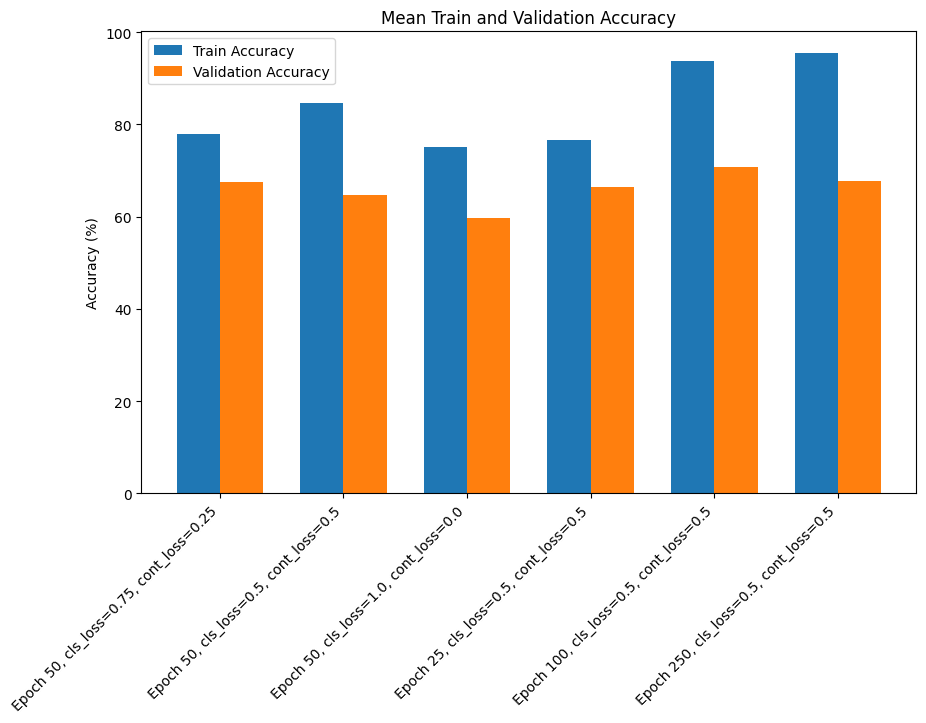

In [49]:
import numpy as np

# Data
means_train = [78.0, 84.74, 75.01, 76.62, 93.66, 95.38]
means_val = [67.60, 64.65, 59.75, 66.45, 70.80, 67.70]
labels = ['Epoch 50, cls_loss=0.75, cont_loss=0.25', 'Epoch 50, cls_loss=0.5, cont_loss=0.5',          'Epoch 50, cls_loss=1.0, cont_loss=0.0', 'Epoch 25, cls_loss=0.5, cont_loss=0.5',          'Epoch 100, cls_loss=0.5, cont_loss=0.5', 'Epoch 250, cls_loss=0.5, cont_loss=0.5']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.35
ax.bar(x - width/2, means_train, width,  label='Train Accuracy')
ax.bar(x + width/2, means_val, width,  label='Validation Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Mean Train and Validation Accuracy')
ax.legend()
plt.show()


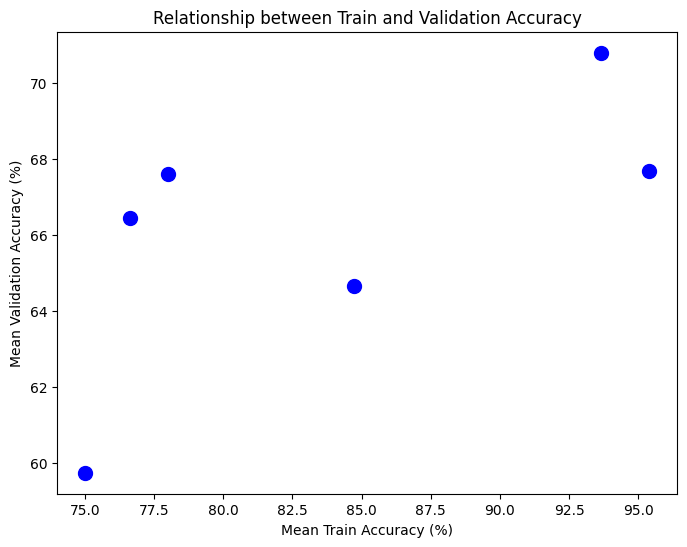

In [50]:
import matplotlib.pyplot as plt

# Data
means_train = [78.0, 84.74, 75.01, 76.62, 93.66, 95.38]
means_val = [67.60, 64.65, 59.75, 66.45, 70.80, 67.70]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(means_train, means_val, s=100, c='blue')
ax.set_xlabel('Mean Train Accuracy (%)')
ax.set_ylabel('Mean Validation Accuracy (%)')
ax.set_title('Relationship between Train and Validation Accuracy')
plt.show()


The below tries  2 random problem instances. In your development you may choose to prototype with 1 problem instances but keep in mind for small sample problems the variance is high so continously evaluating on several subsets will be important.

***Challenge 2***

You may use the same testbed but without the constraints on external datasets or models trained on exeternal datasets. You may not however use any of the CIFAR-10 training set. 

In [57]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

resize = transforms.Resize(256) #Resize to use with AlexNet

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

train_accs = []
test_accs = []

for seed in range(0, 25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  
  config = dict(batch_size=64,
                  epochs=50,
                  learning_rate=0.0001,
                  momentum=0.9,
                  weight_decay=5e-4)

  net_aug = AugNet()
  net_aug.to(device)
  net_aug.train()

  alex = t_models.alexnet(pretrained=True).to(device)
  alex.train()
  for param in alex.parameters():
    param.requires_grad = False
  alex.classifier = nn.Linear(256 * 6 * 6, 10)
  alex.classifier.to(device)

  alexnet_loss = nn.CrossEntropyLoss()

  optimizer = optim.Adam(list(alex.classifier.parameters()) + list(net_aug.parameters()), lr=config["learning_rate"], weight_decay=config["weight_decay"])

  
  

  correct = 0
  total = 0
  for epoch in tqdm(range(config['epochs']), desc=f'training model'):
    
    for j, data in enumerate(train_loader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        for input, label in zip(inputs, labels):

          input = input.to(device)
          

          output_sm1 = alex(input.unsqueeze(0)) #1,3,256,256

          pred = torch.argmax(output_sm1) #tensor(0, device='cuda:0')

          if pred == label:
            correct += 1
          total += 1   

          loss_sm1 = alexnet_loss(output_sm1.squeeze(), label)
   
          # Generate Aug Image

          class_indices = [idx for idx, _ in enumerate(inputs) if labels[idx] == label]

          sampled_indices = torch.randperm(len(class_indices))[:3]


          aug_image = torch.cat([inputs[sampled_indices[0]], inputs[sampled_indices[1]]], dim=0).to(device)
          aug_image_compare = inputs[sampled_indices[2]]

          
          output_aug = net_aug(aug_image)
          

          C, W, H = output_aug.shape

          content_loss = torch.sum((output_aug - aug_image_compare) ** 2) / (C * W * H)

          output_aug = output_aug.to(device)
          output_sm2 = alex(output_aug.unsqueeze(0))

          loss_sm2 = alexnet_loss(output_sm2.squeeze(), label)

          total_loss = 0.5 * (loss_sm1 + loss_sm2) + 0.5 * content_loss

          
          optimizer.zero_grad()
          total_loss.backward()
          optimizer.step()


  acc = 100. * (correct) / total      
  train_accs.append(acc)
  print('Seed {}/{} Loss: {} Accuracy: {:.2f}%'.format(seed + 1, 25, total_loss, acc))
  test_accs.append(test(alex, device, val_loader))

print(f'Mean Train Acc over 25 models: '\
      f'{np.mean(train_accs)/ 100 :.2%} '\
      f'+- {np.std(train_accs):.2}')

print(f'Mean Val Acc over 25 models: '\
      f'{np.mean(test_accs)/ 100 :.2%} '\
      f'+- {np.std(test_accs):.2}')


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 1/25 Loss: 1.1475062370300293 Accuracy: 99.24%

Test set: Average loss: 0.0682, Accuracy: 392/400 (98.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 2/25 Loss: 0.8468173146247864 Accuracy: 98.88%

Test set: Average loss: 0.3526, Accuracy: 346/400 (86.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 3/25 Loss: 0.7083760499954224 Accuracy: 99.36%

Test set: Average loss: 0.3037, Accuracy: 346/400 (86.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 4/25 Loss: 0.8623078465461731 Accuracy: 99.36%

Test set: Average loss: 0.1078, Accuracy: 381/400 (95.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 5/25 Loss: 0.5627000331878662 Accuracy: 98.96%

Test set: Average loss: 0.3343, Accuracy: 345/400 (86.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 6/25 Loss: 0.7940574884414673 Accuracy: 98.92%

Test set: Average loss: 0.4250, Accuracy: 324/400 (81.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 7/25 Loss: 0.9259098768234253 Accuracy: 99.24%

Test set: Average loss: 0.0725, Accuracy: 387/400 (96.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 8/25 Loss: 1.0132018327713013 Accuracy: 99.36%

Test set: Average loss: 0.0562, Accuracy: 395/400 (98.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 9/25 Loss: 1.032790184020996 Accuracy: 99.48%

Test set: Average loss: 0.0873, Accuracy: 389/400 (97.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 10/25 Loss: 1.7898868322372437 Accuracy: 99.08%

Test set: Average loss: 0.3647, Accuracy: 345/400 (86.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 11/25 Loss: 1.0725632905960083 Accuracy: 99.12%

Test set: Average loss: 0.2968, Accuracy: 360/400 (90.00%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 12/25 Loss: 0.5842145681381226 Accuracy: 99.36%

Test set: Average loss: 0.0696, Accuracy: 393/400 (98.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 13/25 Loss: 0.9554958939552307 Accuracy: 99.44%

Test set: Average loss: 0.0960, Accuracy: 391/400 (97.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 14/25 Loss: 1.9094743728637695 Accuracy: 98.88%

Test set: Average loss: 0.1653, Accuracy: 374/400 (93.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 15/25 Loss: 0.9889696836471558 Accuracy: 99.48%

Test set: Average loss: 0.1375, Accuracy: 377/400 (94.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 16/25 Loss: 0.7188801169395447 Accuracy: 99.08%

Test set: Average loss: 0.1646, Accuracy: 375/400 (93.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 17/25 Loss: 1.112615704536438 Accuracy: 99.36%

Test set: Average loss: 0.0844, Accuracy: 386/400 (96.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 18/25 Loss: 1.2219234704971313 Accuracy: 99.28%

Test set: Average loss: 0.0966, Accuracy: 387/400 (96.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 19/25 Loss: 1.0950946807861328 Accuracy: 98.96%

Test set: Average loss: 0.5027, Accuracy: 314/400 (78.50%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 20/25 Loss: 1.4351731538772583 Accuracy: 98.92%

Test set: Average loss: 0.4833, Accuracy: 327/400 (81.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 21/25 Loss: 1.2502249479293823 Accuracy: 99.40%

Test set: Average loss: 0.1107, Accuracy: 381/400 (95.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 22/25 Loss: 0.7972770929336548 Accuracy: 98.76%

Test set: Average loss: 0.3804, Accuracy: 343/400 (85.75%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 23/25 Loss: 1.0532728433609009 Accuracy: 99.24%

Test set: Average loss: 0.1215, Accuracy: 381/400 (95.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 24/25 Loss: 0.6735818386077881 Accuracy: 98.76%

Test set: Average loss: 0.3124, Accuracy: 349/400 (87.25%)

Num Samples For Training 50 Num Samples For Val 400


training model:   0%|          | 0/50 [00:00<?, ?it/s]

Seed 25/25 Loss: 0.7439010143280029 Accuracy: 98.96%

Test set: Average loss: 0.4061, Accuracy: 330/400 (82.50%)

Mean Train Acc over 25 models: 99.16% +- 0.23
Mean Val Acc over 25 models: 91.18% +- 6.2


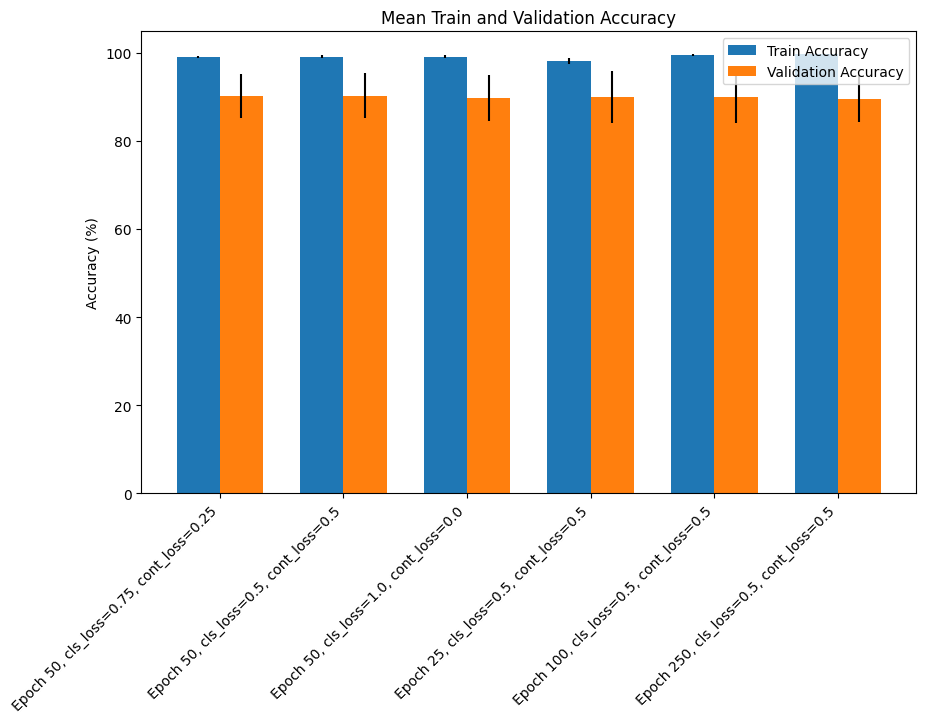

In [46]:
import numpy as np

# Data
means_train = [99.05, 99.14, 99.13, 98.13, 99.48, 99.82]
stds_train = [0.33, 0.26, 0.31, 0.63, 0.18, 0.04]
means_val = [90.20, 90.30, 89.80, 90.05, 90.05, 89.60]
stds_val = [5.0, 5.1, 5.2, 5.9, 6.0, 5.4]
labels = ['Epoch 50, cls_loss=0.75, cont_loss=0.25', 'Epoch 50, cls_loss=0.5, cont_loss=0.5',          'Epoch 50, cls_loss=1.0, cont_loss=0.0', 'Epoch 25, cls_loss=0.5, cont_loss=0.5',          'Epoch 100, cls_loss=0.5, cont_loss=0.5', 'Epoch 250, cls_loss=0.5, cont_loss=0.5']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.35
ax.bar(x - width/2, means_train, width, yerr=stds_train, label='Train Accuracy')
ax.bar(x + width/2, means_val, width, yerr=stds_val, label='Validation Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Mean Train and Validation Accuracy')
ax.legend()
plt.show()


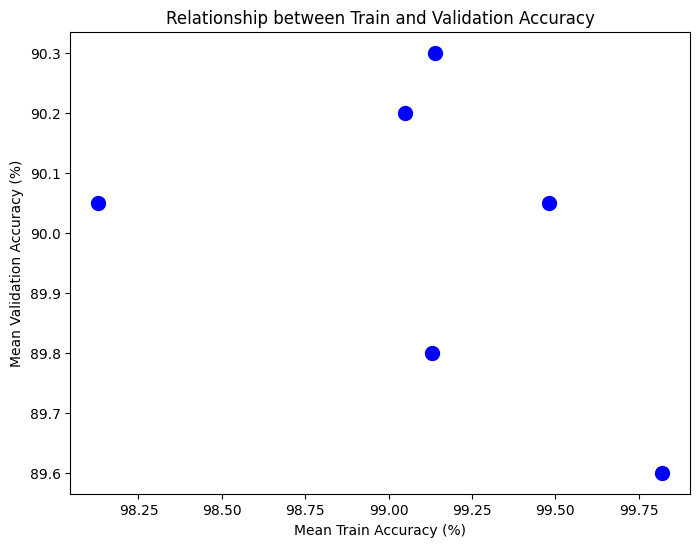

In [47]:
import matplotlib.pyplot as plt

# Data
means_train = [99.05, 99.14, 99.13, 98.13, 99.48, 99.82]
means_val = [90.20, 90.30, 89.80, 90.05, 90.05, 89.60]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(means_train, means_val, s=100, c='blue')
ax.set_xlabel('Mean Train Accuracy (%)')
ax.set_ylabel('Mean Validation Accuracy (%)')
ax.set_title('Relationship between Train and Validation Accuracy')
plt.show()
